In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.1
GPU detected: []


In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Sentence #,Word,POS,Tag,Unnamed: 4,Unnamed: 5
0,Sentence: 1,Thousands,NNS,O,NaN,NaN
1,Sentence: 1,of,IN,O,NaN,NaN
2,Sentence: 1,demonstrators,NNS,O,NaN,NaN
3,Sentence: 1,have,VBP,O,NaN,NaN
4,Sentence: 1,marched,VBN,O,NaN,NaN
5,Sentence: 1,through,IN,O,NaN,NaN
6,Sentence: 1,London,NNP,B-geo,NaN,NaN
7,Sentence: 1,to,TO,O,NaN,NaN
8,Sentence: 1,protest,VB,O,NaN,NaN
9,Sentence: 1,the,DT,O,NaN,NaN


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35155
Unique tags in corpus: 18


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'above': 1,
 'appearing': 2,
 'hard-line': 3,
 'Palestinian-ruled': 4,
 'Advertisers': 5,
 'Amagasaki': 6,
 'divisive': 7,
 're-measured': 8,
 'trees': 9,
 'seats': 10,
 'outlaw': 11,
 'ignite': 12,
 'Annual': 13,
 'Office': 14,
 'Mexico-U.S.': 15,
 'entire': 16,
 'Fellow': 17,
 'debilitating': 18,
 'BP': 19,
 'Operating': 20,
 'Elders': 21,
 'Beethoven': 22,
 'amputation': 23,
 'Mizarkhel': 24,
 'Walker': 25,
 'rotating': 26,
 'suggests': 27,
 'thrifty': 28,
 'demarcated': 29,
 'mortgage-backed': 30,
 'infringe': 31,
 '169': 32,
 'Shooting': 33,
 'impress': 34,
 'effigies': 35,
 'bull': 36,
 '6,500-strong': 37,
 'preparations': 38,
 'Will': 39,
 'Aceh-based': 40,
 '34-year-old': 41,
 'indication': 42,
 'well-established': 43,
 'ambulance': 44,
 '1,72,000': 45,
 'Diamondbacks': 46,
 'Kewell': 47,
 'slimy': 48,
 'accused': 49,
 'Islamists': 50,
 'burns': 51,
 'Anglo-Leasing': 52,
 'forbade': 53,
 'stages': 54,
 'Owl': 55,
 'Qaida-linked': 56,
 'skipped': 57,
 'Duke': 58,
 'Government':

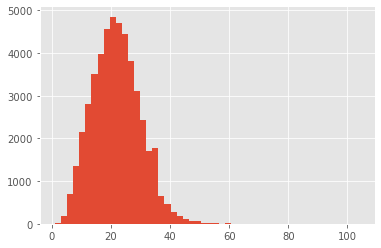

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1757800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 18)           3618      
 ibuted)                                                         
                                                             

In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

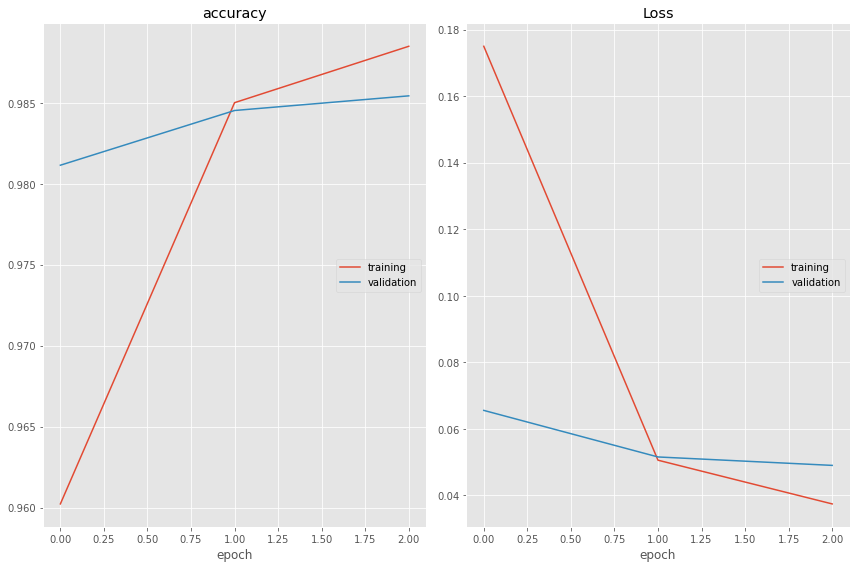

accuracy
	training         	 (min:    0.960, max:    0.988, cur:    0.988)
	validation       	 (min:    0.981, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.037, max:    0.175, cur:    0.037)
	validation       	 (min:    0.049, max:    0.066, cur:    0.049)

Epoch 3: val_loss improved from 0.05154 to 0.04901, saving model to model_weights.h5
1199/1199 [==============================] - 152s 127ms/step - loss: 0.0374 - accuracy: 0.9885 - val_loss: 0.0490 - val_accuracy: 0.9854
Wall time: 7min 48s


In [18]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [19]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 7s 24ms/step - loss: 0.0490 - accuracy: 0.9854


[0.049010567367076874, 0.9854295253753662]

In [20]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 844ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean     O	O
Panggabean   

In [22]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp("Karthik the economic meltdown has reached Big Tech ,The Microsoft and Google has become the first tech giant to lay off employees as part of a India.The layoffs at Microsoft reportedly affect nearly 1% of its 1,80,000-strong workforce across its offices and product divisions.")
displacy.render(text, style = 'ent', jupyter=True)